- **Author:** Dace Apšvalka, MRC CBU
- **Date:** February 2026
- **Requirements:** MNE-Python, meg_event_utils repository

# Utility functions for extracting, inspecting, and cleaning MEG trigger events on Neuromag Vectorview and MEGIN Neo MEG systems

> 💡 The functions in this package were developed specifically for **Neuromag Vectorview and MEGIN Neo MEG systems** at the MRC Cognition and Brain Sciences Unit (CBU). This is **not a polished, general-purpose package**: it grew out of practical work on two legacy datasets acquired at the CBU.

> 💡 This tutorial focuses on the main functionality of `meg_event_utils` rather than covering every available function. Each function in the package is documented in its docstring, and curious users are encouraged to explore the code and documentation on their own.

## Background

In most MEG experiments, the stimulus delivery program (e.g. PsychoPy, Presentation, E-Prime) sends event triggers to the MEG system, which are recorded on one or more trigger channels. These triggers are the backbone of epoching and condition labelling: they tell us what happened when.

Depending on the MEG system, triggers may be saved as multiple separate "bit" channels (each representing one digital line) and/or as a single summed channel, which encodes the binary state of all bit channels as an integer. For example, in the Neuromag Vectorview and MEGIN Neo MEG systems, there are 16 bit channels labelled **STI001** to **STI016**, and a summed channel labelled **STI101**. The value at each sample in STI101 is the weighted sum of the bit channels (STI001 × 1, STI002 × 2, STI003 × 4, etc.). Typically, the first 8 bit channels are used to encode **stimulus events** (allowing unique codes from 1 to 255 in STI101), while the remaining 8 channels are used to encode **button presses**. This can lead to values in STI101 ranging from 512 up to 65,535 for responses, including unique codes for simultaneous stimulus–response events and for multiple simultaneous button presses.

In practice, however, trigger recordings are often messy. You may encounter spurious pulses, overlapping triggers (e.g. stimulus and keypress at the same time), or incomplete recordings where only a summed trigger channel was saved instead of the individual bit channels. These issues can lead to missing events, extra non-existent events, or mislabelled trials if not handled carefully.

Libraries such as MNE-Python already provide excellent tools for reading and extracting events from trigger channels in standard cases. However, in real-world datasets with spurious triggers or overlapping codes, additional inspection and custom handling are often needed. The functions in `meg_event_utils` are designed to complement existing workflows by making these edge cases easier to diagnose and fix.

Below, I describe a typical workflow for inspecting and extracting events, followed by the typical problems and their solutions.


## Typical problems with event triggers and their solutions using `meg_event_utils`

### Problem: Only a summed STI101 channel is saved, but no separate bit channels

When only the summed trigger channel is available, you lose direct access to the individual bit lines. This makes it harder to see which specific triggers were active at a given time and can complicate debugging, quality control, and recovery of the original event codes, especially when triggers overlap or one or more bit channels has spurious pulses (e.g., a loose connection).

**Solution**

The summed STI101 channel is decomposed into individual channels. This means that even if the original individual channels were not saved, they can be reconstructed from STI101 and inspected separately.


### Problem: Overlapping stimulus and button-press triggers

When stimulus and button-press triggers occur at the same time, their bit patterns are combined in the summed channel. This can create unexpected event codes, leading to mislabelled trials or extra conditions unless the overlap is explicitly detected and handled.

**Solution**

As above, the STI101 channel is first decomposed into individual channels. Then only the stimulus channels (typically STI001 to STI008) are summed, while button-press channels are kept separate (i.e., not included in the sum). This way, overlapping stimulus and button-press triggers do not create new, unwanted event codes.

### Problem: Spurious triggers, creating non-existent stimulus events

Spurious pulses on trigger lines can generate events that never actually occurred in the experiment. If not identified, these false events inflate event counts, shift trial timing, and can contaminate downstream analyses.

**Solution**

In the two legacy datasets I worked with, the spurious triggers typically occurred on the **STI003** channel, and they always happened while a button (STI013, STI015, or STI016) was being pressed (although not every button press produced a spurious STI003 pulse). The practical solution in this case was to remove STI003 triggers that start while STI013, STI015, or STI016 is ON.

In some cases, spurious triggers also appeared when a button was pressed for a very long time. For those situations, the solution was to remove all events occurring during prolonged button presses. 

### Problem: Are my event triggers as I expect them to be?

Even when triggers can be extracted without obvious errors, it is often unclear whether they truly reflect the intended experimental design. Unexpected counts, missing conditions, or suspicious timing patterns can easily go unnoticed and propagate into later analyses.

**Solution**

Create summary reports and diagnostic plots of the trigger channels and extracted events. These allow you to quickly check event counts, inspect the timing and co-occurrence of trigger lines, and spot suspicious patterns before committing to epoching and statistical analysis.

## Set up

You can either use `meg_event_utils` by adding the repository to your Python path, or by installing it in editable mode.

### Option 1: Add the repository to your Python path

```python
import sys
sys.path.append('/path/to/meg_event_utils')
```

### Option 2: Install in editable mode

From a terminal:

```bash
pip install -e /path/to/meg_event_utils
```

### After either of these, you can import the package as usual:

In [1]:
import meg_event_utils as meu
import matplotlib.pyplot as plt

## Example: Inspect the event counts for a couple of subjects

> 💡 This example is written for Neuromag Vectorview and MEGIN Neo MEG systems, which produce raw data files in FIF format

In [2]:
raw_files = [
  '/megdata/camcan/camcan/meg12_0488_cc120795/121015/task_raw.fif',
  '/megdata/camcan/camcan/meg13_0282_cc121428/130606/task_raw.fif'
  ]

The code below performs the following steps for each file:
1. `meu.trigger_misc.get_used_sti_channels`.  
   Checks whether the raw data file contains any trigger (STI) channels at all.

2. `meu.trigger_cleaning.decompose_sti101_in_individual_channels`.  
   Decomposes the summed STI101 channel into individual bit channels. Even if individual channels are present in the file, this function uses only the STI101 channel, which is typically always saved.

3. `meu.trigger_cleaning.sum_stim_channels_and_find_events`. 
   Sums the stimulus channels (by default STI001 to STI008; higher channels are usually button presses) and extracts events and their counts. The main options are:
   - `stim_range` : *tuple*. Range of STI channel numbers to consider as stimulus, instead of button press, channels (default: `(1, 9)`).  
   - `min_duration` : *float*. Minimum duration (in seconds) for an event to be considered valid (default: `0.002`).
   - `shortest_event` : *int*. Minimum number of samples for an event to be considered valid (default: `1`).  
   - `consecutive` : *bool*. If True, only considers consecutive events as valid (default: `True`).   
   - `verbose` : *bool*. If True, prints verbose output (default: `True`). 

4. `meu.trigger_reporting.print_event_counts_table`.  
   Prints a simple event count table, with event codes in the top row and their number of occurrences in the bottom row. 
   
5. `meu.trigger_plotting.create_basic_plot`.  
   Plots the time courses of the individual bit channels (as decomposed from the summed STI101). Each channel is shown as a binary (0/1) time series indicating whether it is OFF or ON at a given time point. 

Inspecting raw file: /megdata/camcan/camcan/meg12_0488_cc120795/121015/task_raw.fif
Unique values found: [1, 2, 3, 4, 5, 4096]; Individual channels: ['STI001', 'STI002', 'STI003', 'STI013']
Stimulus channels considered for summing: ['STI001', 'STI002', 'STI003', 'STI004', 'STI005', 'STI006', 'STI007', 'STI008']
Event Counts:
------------------------------------------------
  1    |   2    |   3    |   4    |   5    |  4096 
------------------------------------------------
  40   |   40   |   40   |   4    |   4    |  130  
------------------------------------------------


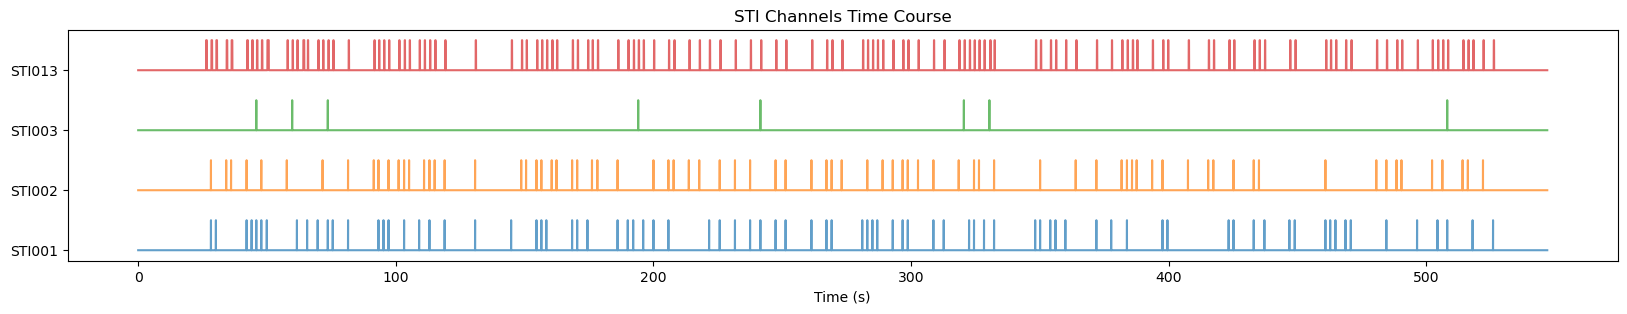

Inspecting raw file: /megdata/camcan/camcan/meg13_0282_cc121428/130606/task_raw.fif
Unique values found: [-32768, -32764, 1, 2, 3, 4, 5, 7]; Individual channels: ['STI001', 'STI002', 'STI003', 'STI016']
Stimulus channels considered for summing: ['STI001', 'STI002', 'STI003', 'STI004', 'STI005', 'STI006', 'STI007', 'STI008']
Event Counts:
------------------------------------------------
  1    |   2    |   3    |   4    |   5    | 32768 
------------------------------------------------
  40   |   40   |   40   |   10   |   4    |  130  
------------------------------------------------


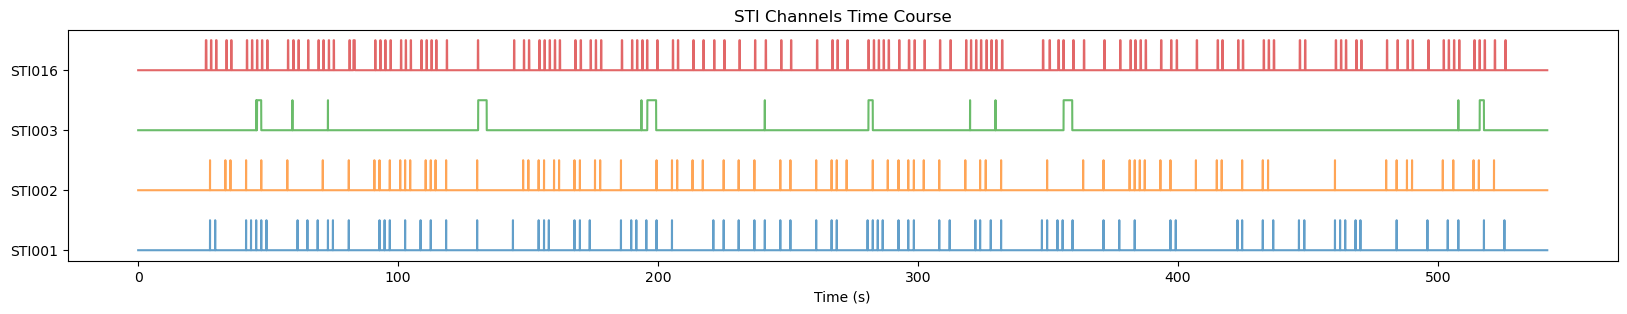

In [3]:
for raw_file in raw_files:
  print("="*100)
  print(f"Inspecting raw file: {raw_file}")
  print("="*100)

  # 1. Check if any STI channels are used at all
  used_sti_channels = meu.trigger_misc.get_used_sti_channels(raw_file)
  
  if used_sti_channels:
    # 2. Decompose the STI101 channel into individual channels
    time_series_array, individual_channels, raw = meu.trigger_cleaning.decompose_sti101_in_individual_channels(raw_file=raw_file, verbose=True)
    
    # 3. Sum the individual stimulus channels to find events and event counts
    events, event_counts = meu.trigger_cleaning.sum_stim_channels_and_find_events(time_series_array, individual_channels, raw)
    
    # 4. Print the event counts table
    meu.trigger_reporting.print_event_counts_table(event_counts)
    
    # 5. Plot the time course of the individual STI channels
    plt.figure(figsize=(20, 3))
    plt = meu.trigger_plotting.create_basic_plot(time_series_array, raw.times, individual_channels, title="STI Channels Time Course")
    plt.show()
    
  else:
    print(f"No STI channels used in {raw_file}")

### Spurious trigger issue

In the example above, the first file returns the expected number of occurrences for each event code. In contrast, the second file contains many more occurrences of **event code 4** than expected. In the corresponding plot, you can see spurious activity on **STI003**, suggesting that this bit is occasionally turning on when it should not.

If you want to investigate this further, you can generate an interactive plot and save it as an HTML file. This allows you to zoom in on specific time windows and inspect which trigger lines were active during suspicious moments.

In [4]:
# get the time course of the individual STI channels for the second raw file
time_series_array, individual_channels, raw = meu.trigger_cleaning.decompose_sti101_in_individual_channels(raw_file=raw_files[1])

# create and save an interactive plot
fig = meu.trigger_plotting.create_interactive_plot(time_series_array, raw.times, individual_channels, title="STI Channels Time Course")
fig.write_html("reports/meg13_0282_cc121428_sti_channels_time_course.html")

Unique values found: [-32768, -32764, 1, 2, 3, 4, 5, 7]; Individual channels: ['STI001', 'STI002', 'STI003', 'STI016']


After opening the saved HTML file, you can zoom in on the first suspicious STI003 pulse. Hovering over the traces shows that when the spurious STI003 trigger turns on, a button press (**STI016)** is also active. Inspecting the other spurious STI003 occurrences reveals the same pattern: they occur while STI016 is ON (although not every STI016 button press produces a spurious STI003 pulse).

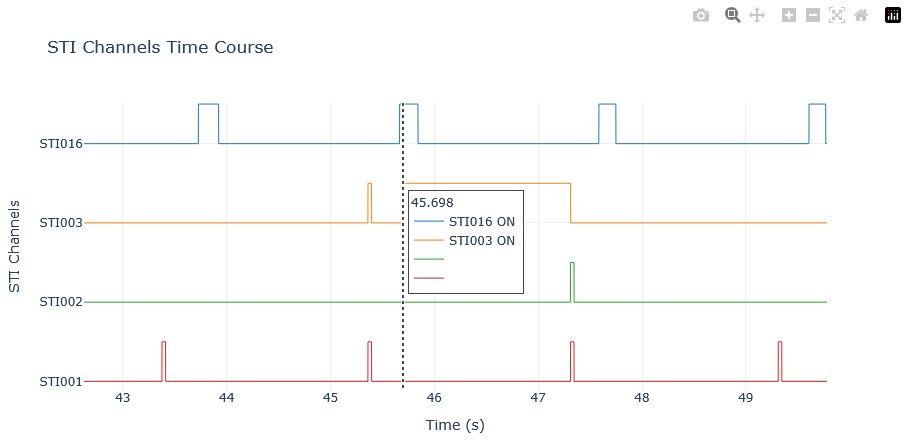

This kind of co-occurrence can reflect trigger-line cross-talk or recording artefacts, and it is a good reason to inspect the raw trigger traces rather than relying on event counts alone.

### Cleaning the event triggers

Let’s apply the cleaning function and check whether it fixes the issue in this raw file:


In [5]:
cleaned_time_series, removed_events = meu.trigger_cleaning.clean_sti101_timeseries(data101=time_series_array, sti_channels=individual_channels, verbose=True)

STI003 came ON while STI013/015/016 was ON; Removed STI003 1619 timepoints between 45693-47313 where no other STI001-STI008 channels were active.
STI003 came ON while STI013/015/016 was ON; Removed STI003 3289 timepoints between 130752-134041 where no other STI001-STI008 channels were active.
STI003 came ON while STI013/015/016 was ON; Removed STI003 3400 timepoints between 195813-199213 where no other STI001-STI008 channels were active.
STI003 came ON while STI013/015/016 was ON; Removed STI003 1667 timepoints between 280872-282540 where no other STI001-STI008 channels were active.
STI003 came ON while STI013/015/016 was ON; Removed STI003 3333 timepoints between 355932-359265 where no other STI001-STI008 channels were active.
STI003 came ON while STI013/015/016 was ON; Removed STI003 1628 timepoints between 515988-517616 where no other STI001-STI008 channels were active.
Removed short STI003 event at timepoints 47312 to 47313.
Removed short STI003 event at timepoints 282539 to 282540

Now we can sum the stimulus channels in the cleaned time series, extract events, print the event counts, and plot the cleaned trigger traces:

Stimulus channels considered for summing: ['STI001', 'STI002', 'STI003', 'STI004', 'STI005', 'STI006', 'STI007', 'STI008']
Event Counts:
------------------------------------------------
  1    |   2    |   3    |   4    |   5    | 32768 
------------------------------------------------
  40   |   40   |   40   |   4    |   4    |  130  
------------------------------------------------


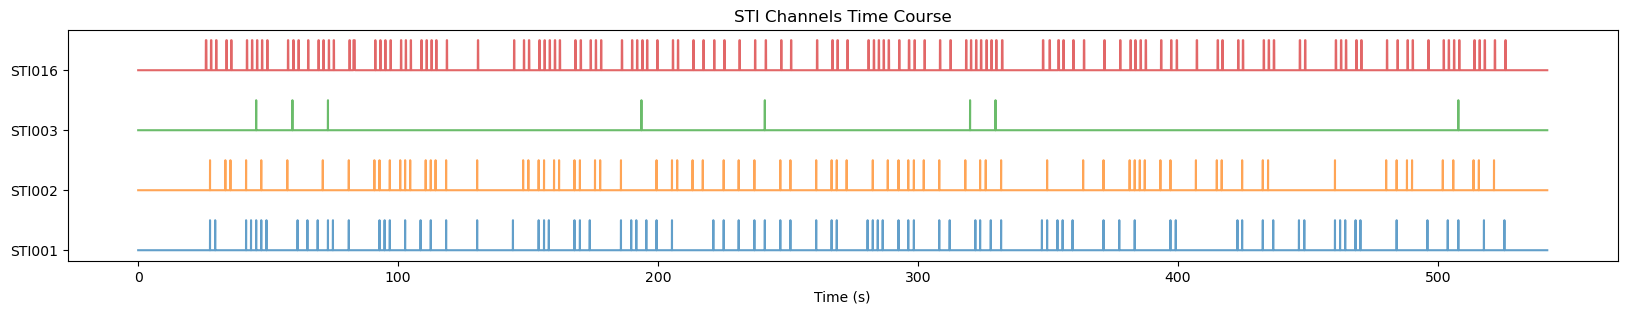

In [6]:
events, event_counts = meu.trigger_cleaning.sum_stim_channels_and_find_events(cleaned_time_series, individual_channels, raw)

meu.trigger_reporting.print_event_counts_table(event_counts)

plt.figure(figsize=(20, 3))
plt = meu.trigger_plotting.create_basic_plot(cleaned_time_series, raw.times, individual_channels, title="STI Channels Time Course")
plt.show()

In this example, the cleaning function removes the spurious STI003 activity, and the event counts return to the expected values.

If you want to visualise what was removed, you can plot the original trigger traces with the removed events overlaid:

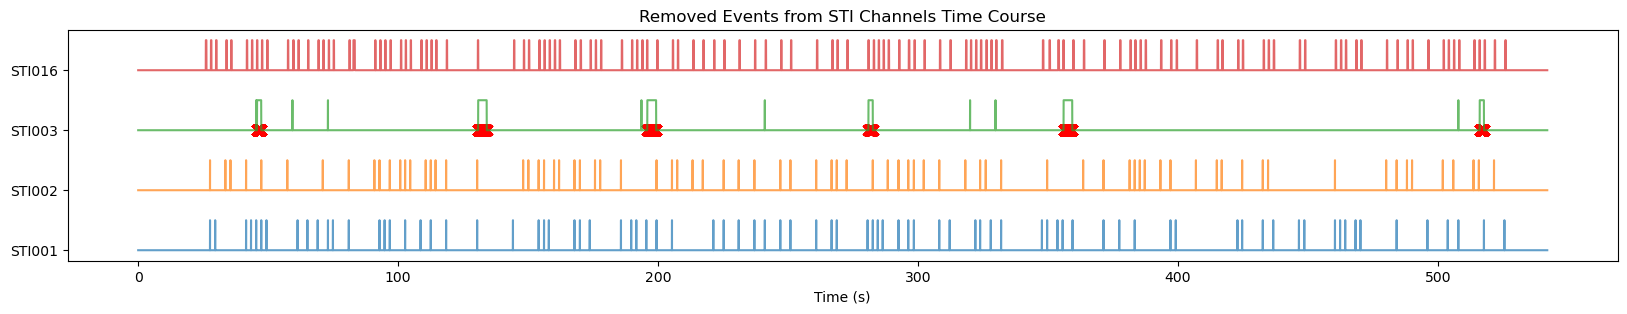

In [7]:
plt.figure(figsize=(20, 3))
meu.trigger_plotting.create_removed_event_plot(time_series_array, raw.times, individual_channels, removed_events, title="Removed Events from STI Channels Time Course")
plt.show()

### Plotting event time courses instead of channel time courses

Sometimes it is more informative to plot event time courses rather than individual trigger-channel time courses. Channel plots show which bit lines are active, but event plots show the decoded event codes over time, which can be easier to interpret and to compare before vs after cleaning.

To do this, first translate the (decomposed) trigger channels into an event time series, and then plot it.

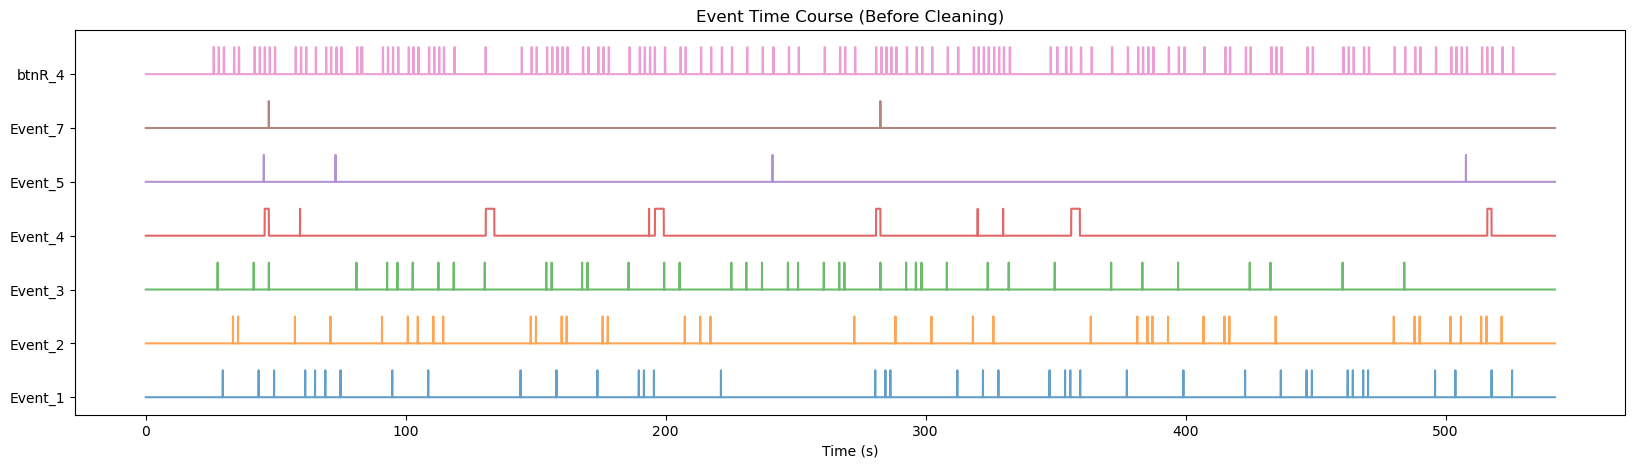

In [8]:
# Translate channels into event time series (before cleaning)
event_time_series, event_names = meu.trigger_cleaning.translate_channels_to_events(time_series_array, individual_channels)

plt.figure(figsize=(20, 5))
plt = meu.trigger_plotting.create_basic_plot(event_time_series, raw.times, event_names, title="Event Time Course (Before Cleaning)")
plt.show()

And the same after cleaning:

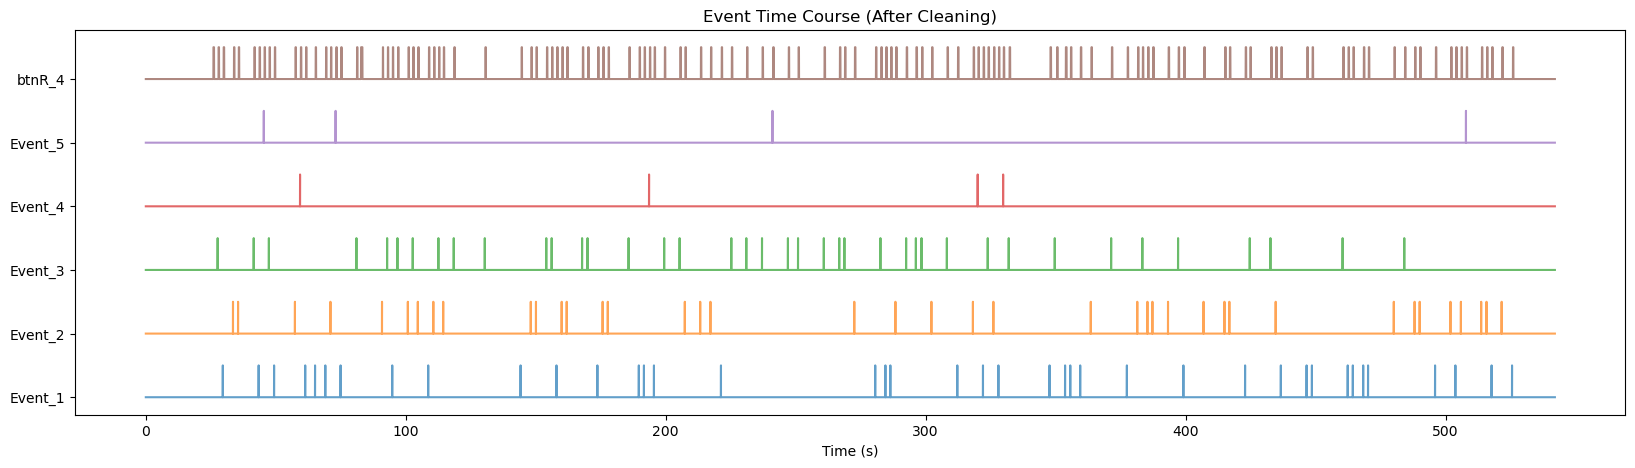

In [9]:
# Translate channels into event time series (after cleaning)
event_time_series, event_names = meu.trigger_cleaning.translate_channels_to_events(cleaned_time_series, individual_channels)

plt.figure(figsize=(20, 5))
plt = meu.trigger_plotting.create_basic_plot(event_time_series, raw.times, event_names, title="Event Time Course (After Cleaning)")
plt.show()

### Creating a BIDS-style events onset table

After extracting and (optionally) cleaning your events, you may want to save them in a format compatible with BIDS. In BIDS datasets, task events are stored in a tab-separated values (TSV) file with at least the columns `onset` (in seconds) and `duration`, and optionally `trial_type` and other metadata.

The function `events_to_bids_tsv` converts an MNE-style `events` array (shape (n_events, 3)) into a BIDS-compliant events table. It computes event onsets in seconds relative to the start of the recording, assigns durations (either fixed or event-specific), and optionally maps numeric event codes to human-readable `trial_type` labels.

If a `raw` object is provided, the sampling frequency and first sample index are extracted automatically. Alternatively, `sfreq` and `first_samp` can be provided manually.

Example: 

In [18]:
events_df = meu.trigger_misc.events_to_bids_tsv(
    events,
    raw=raw,
    event_id={
            'audiovis/300Hz': 1,
            'audiovis/600Hz': 2,
            'audiovis/1200Hz': 3,
            'catch/audio': 4,
            'catch/vis': 5,
            'button': 32768
        },
    output_file='/imaging/correia/da05/wiki/MEG_triggers/reports/sub-CC121428_task-smt_events.tsv', 
    verbose=False
)

events_df.head(20)

,onset,duration,value,trial_type
0,25.991,0.0,32768,button
1,27.606,0.0,3,audiovis/1200Hz
2,27.960,0.0,32768,button
3,29.590,0.0,1,audiovis/300Hz
4,29.925,0.0,32768,button
5,33.508,0.0,2,audiovis/600Hz
6,33.896,0.0,32768,button
7,35.458,0.0,2,audiovis/600Hz
8,35.740,0.0,32768,button
9,41.477,0.0,3,audiovis/1200Hz


> ⚠️ **Important:** For auditory and visual stimuli, hardware-related latencies (e.g., projector delay, audio delivery delay) are often present and should be accounted for when computing event onsets. These latencies are system- and setup-specific and are not corrected automatically by this function. Please consult your MEG technician or acquisition documentation to determine the appropriate latency correction for your system.

### Using events directly with MNE-BIDS

If you are creating a BIDS dataset using MNE-BIDS, you do not necessarily need to write the TSV file manually. Instead, you can pass the cleaned `events` array directly to `mne_bids.write_raw_bids`, which will generate the corresponding `events.tsv` file automatically.

For example:

In [20]:
from mne_bids import write_raw_bids, BIDSPath

bids_path = BIDSPath(
    subject="CC121428",
    task="smt",
    root="/imaging/correia/da05/wiki/MEG_triggers/scratch/BIDS",
)

write_raw_bids(
    raw,
    bids_path=bids_path,
    events=events,
    event_id={
            'audiovis/300Hz': 1,
            'audiovis/600Hz': 2,
            'audiovis/1200Hz': 3,
            'catch/audio': 4,
            'catch/vis': 5,
            'button': 32768
        },
    overwrite=True,
)

Writing '/imaging/correia/da05/wiki/MEG_triggers/scratch/BIDS/README'...
Writing '/imaging/correia/da05/wiki/MEG_triggers/scratch/BIDS/participants.tsv'...
Writing '/imaging/correia/da05/wiki/MEG_triggers/scratch/BIDS/participants.json'...
Writing '/imaging/correia/da05/wiki/MEG_triggers/scratch/BIDS/sub-CC121428/meg/sub-CC121428_coordsystem.json'...
Writing '/imaging/correia/da05/wiki/MEG_triggers/scratch/BIDS/sub-CC121428/meg/sub-CC121428_coordsystem.json'...
Used Annotations descriptions: ['audiovis/1200Hz', 'audiovis/300Hz', 'audiovis/600Hz', 'button', 'catch/audio', 'catch/vis']
Writing '/imaging/correia/da05/wiki/MEG_triggers/scratch/BIDS/sub-CC121428/meg/sub-CC121428_task-smt_events.tsv'...
Writing '/imaging/correia/da05/wiki/MEG_triggers/scratch/BIDS/sub-CC121428/meg/sub-CC121428_task-smt_events.json'...
Writing '/imaging/correia/da05/wiki/MEG_triggers/scratch/BIDS/dataset_description.json'...
Using 5 HPI coils: 293 307 314 321 328 Hz
Using 5 HPI coils: 293 307 314 321 328 Hz
W

BIDSPath(
root: /imaging/correia/da05/wiki/MEG_triggers/scratch/BIDS
datatype: meg
basename: sub-CC121428_task-smt_meg.fif)

In [22]:
import pandas as pd

events_df = pd.read_csv('/imaging/correia/da05/wiki/MEG_triggers/reports/sub-CC121428_task-smt_events.tsv', sep='\t')
events_df.head(20)

,onset,duration,value,trial_type
0,25.991,0.0,32768,button
1,27.606,0.0,3,audiovis/1200Hz
2,27.960,0.0,32768,button
3,29.590,0.0,1,audiovis/300Hz
4,29.925,0.0,32768,button
5,33.508,0.0,2,audiovis/600Hz
6,33.896,0.0,32768,button
7,35.458,0.0,2,audiovis/600Hz
8,35.740,0.0,32768,button
9,41.477,0.0,3,audiovis/1200Hz


## Inspect the event triggers for your whole dataset

It can be useful to inspect event triggers across your whole dataset (or a subset of it) to quickly spot subjects with unexpected event counts or spurious trigger activity. Below is an example script that inspects triggers for `run_01` in the `dgw_studies` dataset:

```bash
ls /megdata/cbu/dgw_studies/meg09_*/*/run_01_raw.fif

/megdata/cbu/dgw_studies/meg09_0089/090407/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0090/090409/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0120/090507/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0126/090511/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0129/090512/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0133/090513/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0134/090514/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0140/090515/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0146/090519/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0148/090519/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0151/090520/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0152/090520/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0153/090521/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0155/090521/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0158/090526/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0159/090528/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0161/090528/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0162/090529/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0163/090529/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0334/091126/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0337/091127/run_01_raw.fif
/megdata/cbu/dgw_studies/meg09_0355/091208/run_01_raw.fif
```

The script below generates a per-subject report (event counts + trigger plot), and then combines all subjects into a single HTML report for convenient inspection.

The example script supports two modes of reporting:

- Not cleaned (`REPORT_CLEANED = False`): Decompose STI101 → sum only stimulus channels → count events → plot decomposed trigger lines.  
**This is often sufficient and is a good first pass.**

- Cleaned (`REPORT_CLEANED = True`): Additionally applies trigger cleaning and plots what was removed.  
This is useful if you already know the dataset has systematic artefacts. 

In [ ]:
import glob
import os
import base64
from io import BytesIO

import matplotlib.pyplot as plt
from tqdm import tqdm

import meg_event_utils as meu


# --- Configuration ---
DATA_DIR = "/megdata/cbu/dgw_studies"
OUTPUT_DIR = "/imaging/correia/da05/wiki/MEG_triggers/reports"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATASET_NAME = "dgw_studies_not_cleaned"
RUN = "run_01"

REPORT_CLEANED = False
# If True: cleans the time series and overlays removed events (create_removed_event_plot)
# If False: reports and plots the raw decomposed time series (create_basic_plot)

# Cleaning configuration (used only if REPORT_CLEANED=True)
CLEANING_STEPS = ["remove_long_press", "remove_sti003", "remove_short_events", "remove_isolated_events"]

# --- Find all run_01_raw.fif files for meg09_* subjects ---
run01_files = {}
for subj_dir in sorted(glob.glob(os.path.join(DATA_DIR, "meg09_*"))):
    subj_id = os.path.basename(subj_dir)
    for date_dir in sorted(os.listdir(subj_dir)):
        fif_path = os.path.join(subj_dir, date_dir, f"{RUN}_raw.fif")
        if os.path.isfile(fif_path):
            run01_files[subj_id] = fif_path
            break  # use the first (and typically only) date folder

print(f"Found {len(run01_files)} subjects with {RUN}_raw.fif")


# --- Process each subject and collect report material ---
subjects_data = {}

for subj_id, fif_path in tqdm(run01_files.items(), desc=f"Processing {DATASET_NAME}", unit="subject"):

    # 1) Check if any STI channels are active
    used_sti_channels = meu.trigger_misc.get_used_sti_channels(fif_path)
    if not used_sti_channels:
        print(f"Skipping {subj_id}: no active STI channels")
        continue

    # 2) Decompose STI101 into individual bit channels (capture verbose output)
    output_text_sti, (time_series_array, channel_names, raw) = meu.trigger_reporting.capture_print_output(
        meu.trigger_cleaning.decompose_sti101_in_individual_channels,
        raw_file=fif_path,
        verbose=True,
    )
    if not channel_names:
        print(f"Skipping {subj_id}: STI101 decomposition returned no channels")
        continue

    # 3) Optionally clean the time series
    if REPORT_CLEANED:
        output_text_clean, (cleaned_time_series, removed_events) = meu.trigger_reporting.capture_print_output(
            meu.trigger_cleaning.clean_sti101_timeseries,
            data101=time_series_array,
            sti_channels=channel_names,
            min_samples=2,
            max_button_samples=20000,
            verbose=True,
            steps=CLEANING_STEPS,
        )

        events, event_counts = meu.trigger_cleaning.sum_stim_channels_and_find_events(
            cleaned_time_series, channel_names, raw, verbose=False
        )

        out_text_table, _ = meu.trigger_reporting.capture_print_output(
            meu.trigger_reporting.print_event_counts_table,
            event_counts,
        )

        output_text = (
            f"File: {fif_path}\n"
            + output_text_sti.strip() + "\n"
            + output_text_clean.strip() + "\n"
            + out_text_table.strip()
        )

        # Plot original traces with removed events overlaid
        plt.figure(figsize=(20, 3))
        meu.trigger_plotting.create_removed_event_plot(
            time_series_array,
            raw.times,
            channel_names,
            removed_events,
            y_offset=2,
            title="Individual Channel Time Courses (removed events overlaid)",
        )

    else:
        events, event_counts = meu.trigger_cleaning.sum_stim_channels_and_find_events(
            time_series_array, channel_names, raw, verbose=False
        )

        out_text_table, _ = meu.trigger_reporting.capture_print_output(
            meu.trigger_reporting.print_event_counts_table,
            event_counts,
        )

        output_text = (
            f"File: {fif_path}\n"
            + output_text_sti.strip() + "\n"
            + out_text_table.strip()
        )

        # Plot decomposed trigger lines
        plt.figure(figsize=(20, 3))
        meu.trigger_plotting.create_basic_plot(
            time_series_array,
            raw.times,
            channel_names,
            title="Individual Channel Time Courses",
        )

    # 4) Save plot as base64 image for HTML embedding
    img_buffer = BytesIO()
    plt.savefig(img_buffer, format="png", bbox_inches="tight")
    plt.close()
    img_data = base64.b64encode(img_buffer.getvalue()).decode()

    subjects_data[subj_id] = (fif_path, output_text, img_data)


# --- Generate HTML report ---
if subjects_data:
    output_html = os.path.join(OUTPUT_DIR, f"Report_MEG_{DATASET_NAME}_{RUN}_Channel_Triggers.html")
    meu.trigger_reporting.generate_html_report(
        subjects_data,
        phase=DATASET_NAME,
        task=RUN,
        output_html=output_html,
        title="MEG Event Triggers",
    )
    print(f"\nReport saved to: {output_html}")
else:
    print("No subjects processed successfully.")
